# Importation des packages et des données

In [1]:
import h5py

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

import skimage
from umap import UMAP

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
import lightgbm as lgb


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as cr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Charger un tableau NumPy à partir du fichier HDF5
with h5py.File('processed_data.h5', 'r') as hf:
    X_txt = hf['text'][:]
    X_img = hf['img'][:]
    y = hf['label'][:]

# Séparation du jeu de données en jeux d'entraînement et de test

In [3]:
X_train_txt, X_val_txt, X_train_img, X_val_img, y_train, y_val = train_test_split(X_txt, X_img, y, 
                                                                                  test_size = 0.2, 
                                                                                  random_state = 0, 
                                                                                  stratify = y)

# Préprocessing

## Undersampling

In [4]:
# Créer un index pour les échantillons d'entraînement
indices_train = np.arange(len(X_train_txt))

# Appliquer RandomUnderSampler aux deux ensembles de données
undersample = RandomUnderSampler(random_state = 0)
indices_resampled, _ = undersample.fit_resample(indices_train.reshape(-1, 1), y_train)

# Utiliser les indices resamplés pour sélectionner les échantillons correspondants dans X_train_txt et X_train_img
X_train_txt_resampled = X_train_txt[indices_resampled.flatten()]
X_train_img_resampled = X_train_img[indices_resampled.flatten()]
y_train_resampled = y_train[indices_resampled.flatten()]

# Vérifier les nouvelles distributions de classes
print('Classes échantillon undersampled :', dict(pd.Series(y_train[indices_resampled.flatten()]).value_counts()))

Classes échantillon undersampled : {10: 489, 1920: 489, 2705: 489, 2585: 489, 2583: 489, 2582: 489, 2522: 489, 2462: 489, 2403: 489, 2280: 489, 2220: 489, 2060: 489, 1940: 489, 1560: 489, 40: 489, 1320: 489, 1302: 489, 1301: 489, 1300: 489, 1281: 489, 1280: 489, 1180: 489, 1160: 489, 1140: 489, 60: 489, 50: 489, 2905: 489}


## Préprocessing des images

In [5]:
class GrayScaleConverter(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])

In [6]:
#Passage des images en niveaux de gris
processor_gray = GrayScaleConverter()
X_train_gray = processor_gray.fit_transform(X_train_img_resampled.reshape(-1, 100, 100, 3))
X_val_gray = processor_gray.transform(X_val_img.reshape(-1, 100, 100, 3))

In [7]:
#UMAP
umap_model = UMAP(n_components = 500)
X_train_img_reduced = umap_model.fit_transform(X_train_gray.reshape(-1, 10000))
X_val_img_reduced = umap_model.transform(X_val_gray.reshape(-1, 10000))

## Préprocessing du texte

In [8]:
#Vectorisation TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_txt_resampled)
X_val_tfidf = vectorizer.transform(X_val_txt)

In [9]:
#Réduction de dimension avec SVD
svd = TruncatedSVD(n_components = 500)
X_train_txt_reduced = svd.fit_transform(X_train_tfidf)
X_val_txt_reduced = svd.transform(X_val_tfidf)

## Recombinaison

In [10]:
X_train_combined = np.concatenate((X_train_txt_reduced, X_train_img_reduced), axis=1)
X_val_combined = np.concatenate((X_val_txt_reduced, X_val_img_reduced), axis=1)

# Modèles Baseline pour texte et images combinés

## Random Forest

In [11]:
%%time
#Entraînement du modèle
rf = RandomForestClassifier(criterion = 'gini', max_depth = None, max_features = 'sqrt', n_estimators = 500, random_state = 0)
rf.fit(X_train_combined, y_train_resampled)
print(f"accuracy : {rf.score(X_val_combined, y_val)}\n")

accuracy : 0.6917641863546037

CPU times: total: 5min 33s
Wall time: 5min 33s


              precision    recall  f1-score   support

          10       0.38      0.55      0.45       499
          40       0.51      0.43      0.47       401
          50       0.61      0.61      0.61       269
          60       0.88      0.80      0.83       133
        1140       0.62      0.67      0.65       427
        1160       0.78      0.80      0.79       632
        1180       0.49      0.55      0.52       122
        1280       0.69      0.36      0.48       779
        1281       0.43      0.49      0.45       331
        1300       0.80      0.79      0.79       807
        1301       0.88      0.88      0.88       129
        1302       0.75      0.60      0.67       399
        1320       0.58      0.60      0.59       519
        1560       0.73      0.67      0.70       812
        1920       0.88      0.82      0.85       689
        1940       0.47      0.78      0.59       128
        2060       0.66      0.68      0.67       799
        2220       0.54    

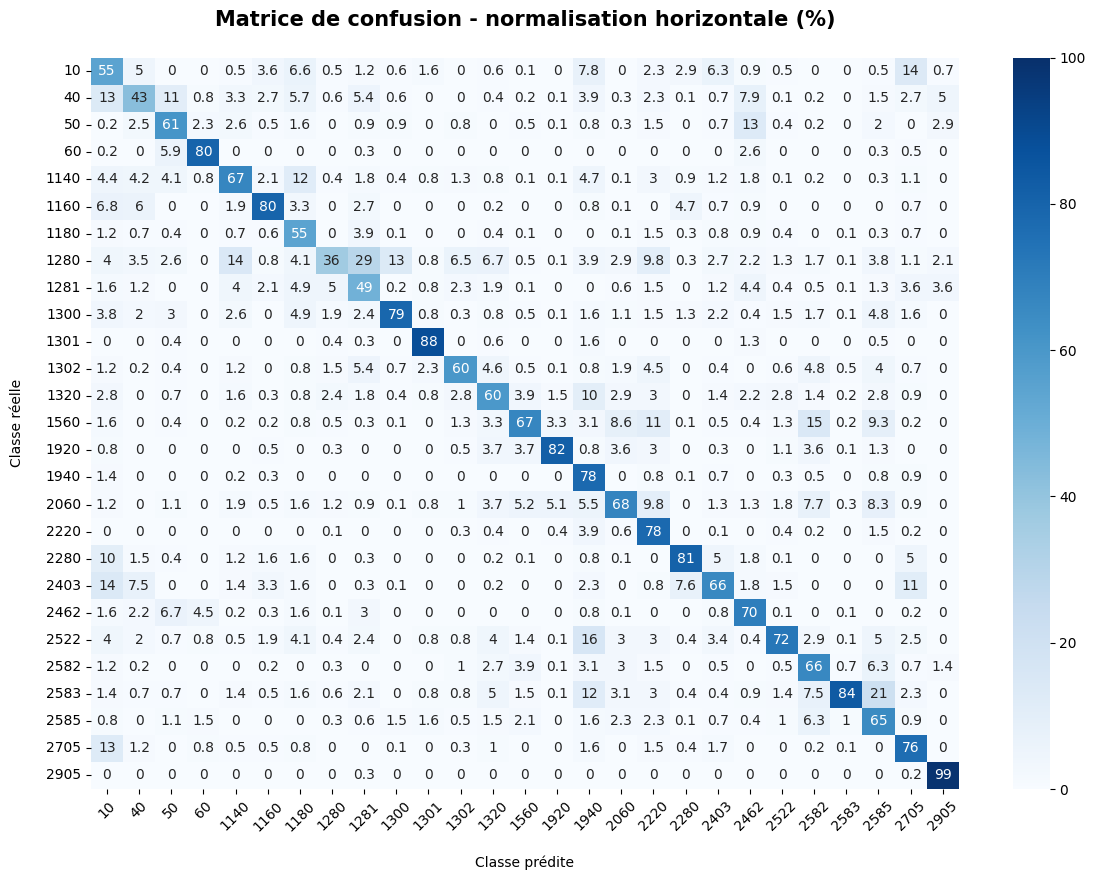

In [12]:
#Rapport de classification
y_pred = rf.predict(X_val_combined)
print(cr(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

## LightGBM

In [13]:
%%time
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled.reshape(-1, 1))
y_val_enc = label_encoder.transform(y_val.reshape(-1, 1))


train_data = lgb.Dataset(X_train_combined, label=y_train_enc)
val_data = lgb.Dataset(X_val_combined, label=y_val_enc)


max_depth = 3
num_leaves = 2 ** max_depth  # 2^max_depth = 32 > 31

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 27,
    'learning_rate': 0.1,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_child_samples': 20,
    'is_unbalance': True,
    'n_estimators': 1000,
    'metric': ['multi_logloss', 'multi_error', 'auc_mu']

}

# Définition des callbacks
callbacks = [
    lgb.early_stopping(
        stopping_rounds=20,
        verbose=False
    )
]

# Entraînement du modèle avec early stopping
model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks,
    num_boost_round=500)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 13203, number of used features: 1000
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[Ligh

In [14]:
#Prédictions sur l'ensemble de test
y_pred_lgb = model.predict(X_val_combined, num_iteration=model.best_iteration)
y_pred_lgb = [np.argmax(pred) for pred in y_pred_lgb]

# Évaluation des performances du modèle
accuracy = accuracy_score(y_val_enc, y_pred_lgb)
print("Accuracy:", accuracy)

Accuracy: 0.717965702509752


              precision    recall  f1-score   support

          10       0.43      0.56      0.48       499
          40       0.56      0.50      0.53       401
          50       0.64      0.68      0.66       269
          60       0.87      0.79      0.83       133
        1140       0.66      0.72      0.69       427
        1160       0.87      0.78      0.82       632
        1180       0.38      0.57      0.46       122
        1280       0.61      0.40      0.48       779
        1281       0.40      0.54      0.46       331
        1300       0.80      0.80      0.80       807
        1301       0.89      0.92      0.90       129
        1302       0.64      0.70      0.67       399
        1320       0.62      0.64      0.63       519
        1560       0.73      0.68      0.70       812
        1920       0.86      0.85      0.86       689
        1940       0.67      0.84      0.75       128
        2060       0.70      0.68      0.69       799
        2220       0.65    

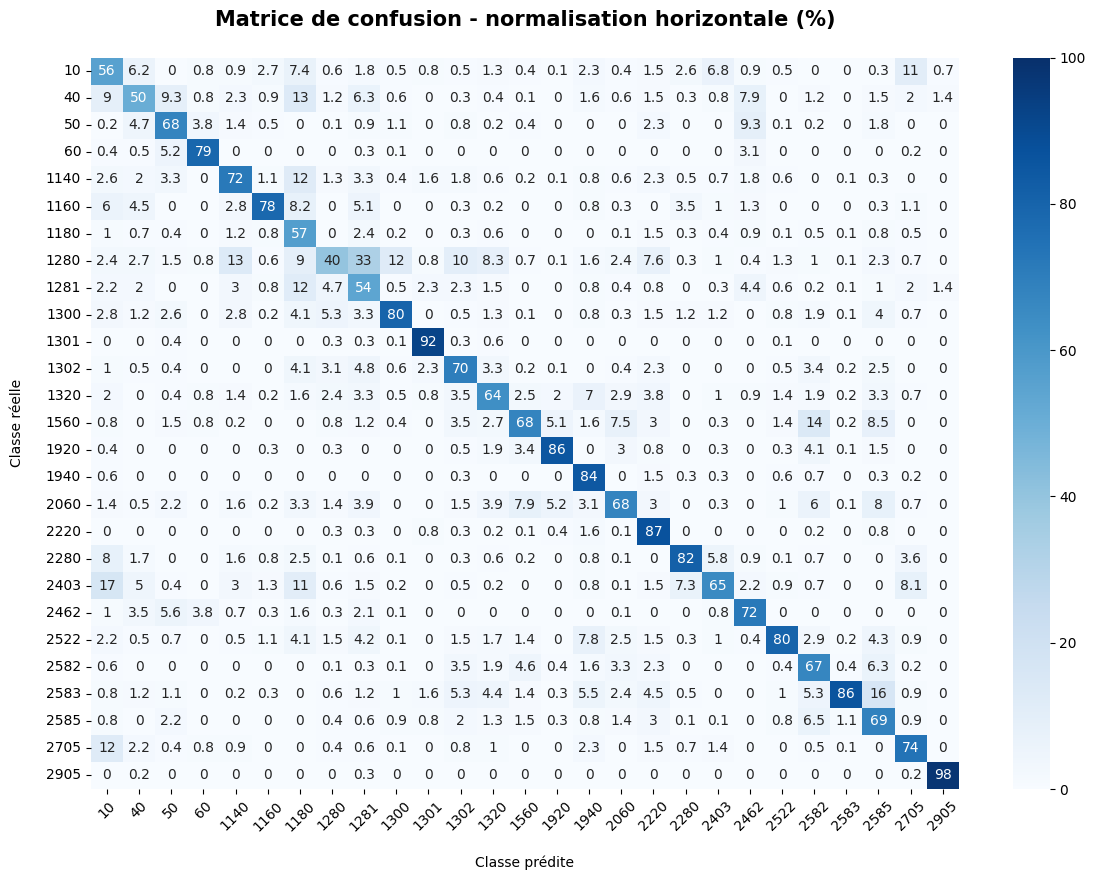

In [15]:
#Rapport de classification
print(cr(np.array(y_val_enc), np.array(y_pred_lgb), target_names=list(map(str,label_encoder.classes_))))

#Matrice de confusion
cm = confusion_matrix(y_val_enc, y_pred_lgb)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val_enc)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues",
            xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

## SGD Classifier

In [16]:
%%time
#Entraînement du modèle
sgd = SGDClassifier(max_iter = 1000, tol = 1e-3)
sgd.fit(X_train_combined, y_train_resampled)
print(f"accuracy : {sgd.score(X_val_combined, y_val)}\n")

accuracy : 0.1478619268418341

CPU times: total: 54.4 s
Wall time: 54.2 s


              precision    recall  f1-score   support

          10       0.13      0.47      0.20       499
          40       0.00      0.00      0.00       401
          50       0.50      0.00      0.01       269
          60       0.00      0.00      0.00       133
        1140       1.00      0.00      0.00       427
        1160       0.00      0.00      0.00       632
        1180       0.00      0.00      0.00       122
        1280       0.00      0.00      0.00       779
        1281       0.00      0.00      0.00       331
        1300       0.00      0.00      0.00       807
        1301       1.00      0.02      0.03       129
        1302       0.00      0.00      0.00       399
        1320       0.00      0.00      0.00       519
        1560       0.39      0.21      0.27       812
        1920       0.78      0.54      0.64       689
        1940       0.02      0.78      0.04       128
        2060       0.00      0.00      0.00       799
        2220       0.02    

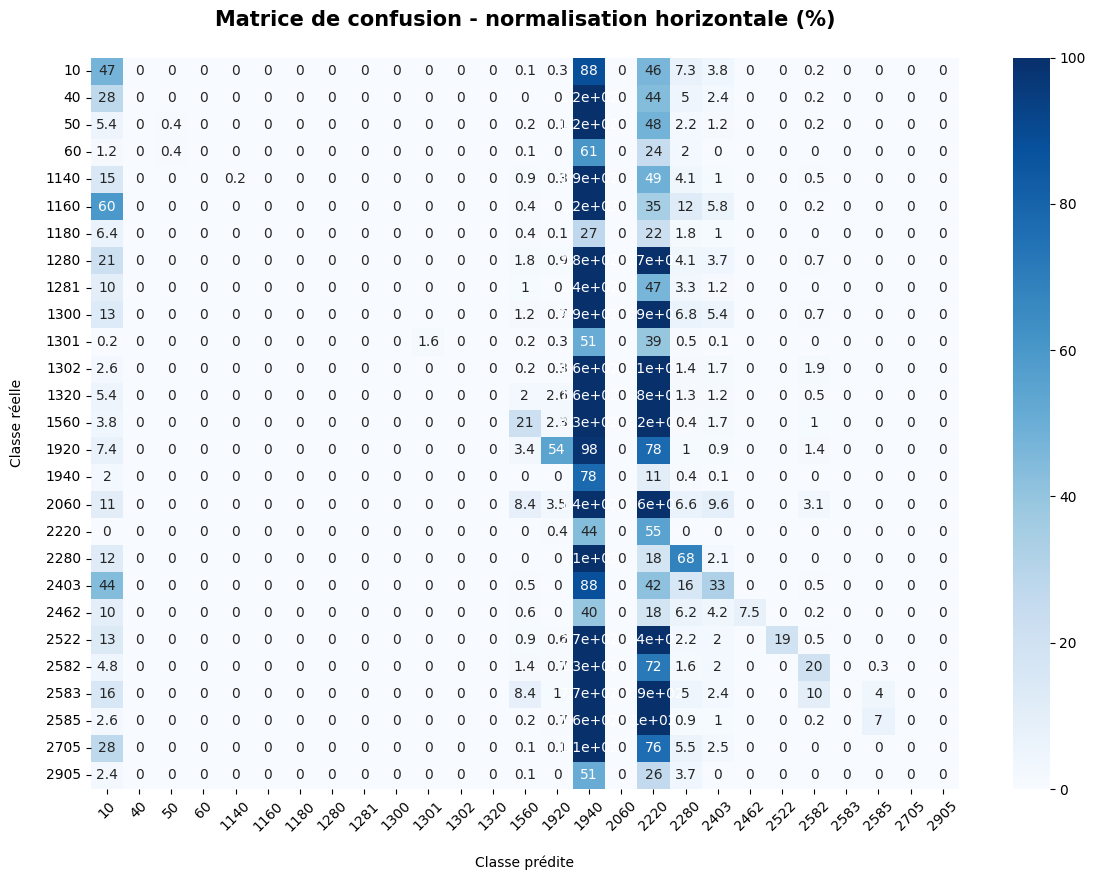

In [17]:
#Rapport de classification
y_pred = sgd.predict(X_val_combined)
print(cr(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

# Modèles baseline pour texte et images séparés

## Random Forest

### Images

In [18]:
%%time
#Entraînement du modèle
rf_img = RandomForestClassifier(criterion = 'gini', max_depth = None, max_features = 'sqrt', n_estimators = 500)
rf_img.fit(X_train_img_reduced, y_train_resampled)
print(f"accuracy : {rf_img.score(X_val_img_reduced, y_val)}\n")

accuracy : 0.16147788327077353

CPU times: total: 4min 30s
Wall time: 4min 30s


              precision    recall  f1-score   support

          10       0.15      0.17      0.16       499
          40       0.09      0.07      0.08       401
          50       0.09      0.12      0.10       269
          60       0.06      0.20      0.10       133
        1140       0.09      0.06      0.07       427
        1160       0.39      0.42      0.40       632
        1180       0.06      0.16      0.08       122
        1280       0.09      0.03      0.04       779
        1281       0.03      0.02      0.03       331
        1300       0.16      0.07      0.10       807
        1301       0.05      0.15      0.07       129
        1302       0.08      0.08      0.08       399
        1320       0.13      0.11      0.12       519
        1560       0.21      0.14      0.17       812
        1920       0.37      0.35      0.36       689
        1940       0.03      0.15      0.05       128
        2060       0.20      0.16      0.18       799
        2220       0.03    

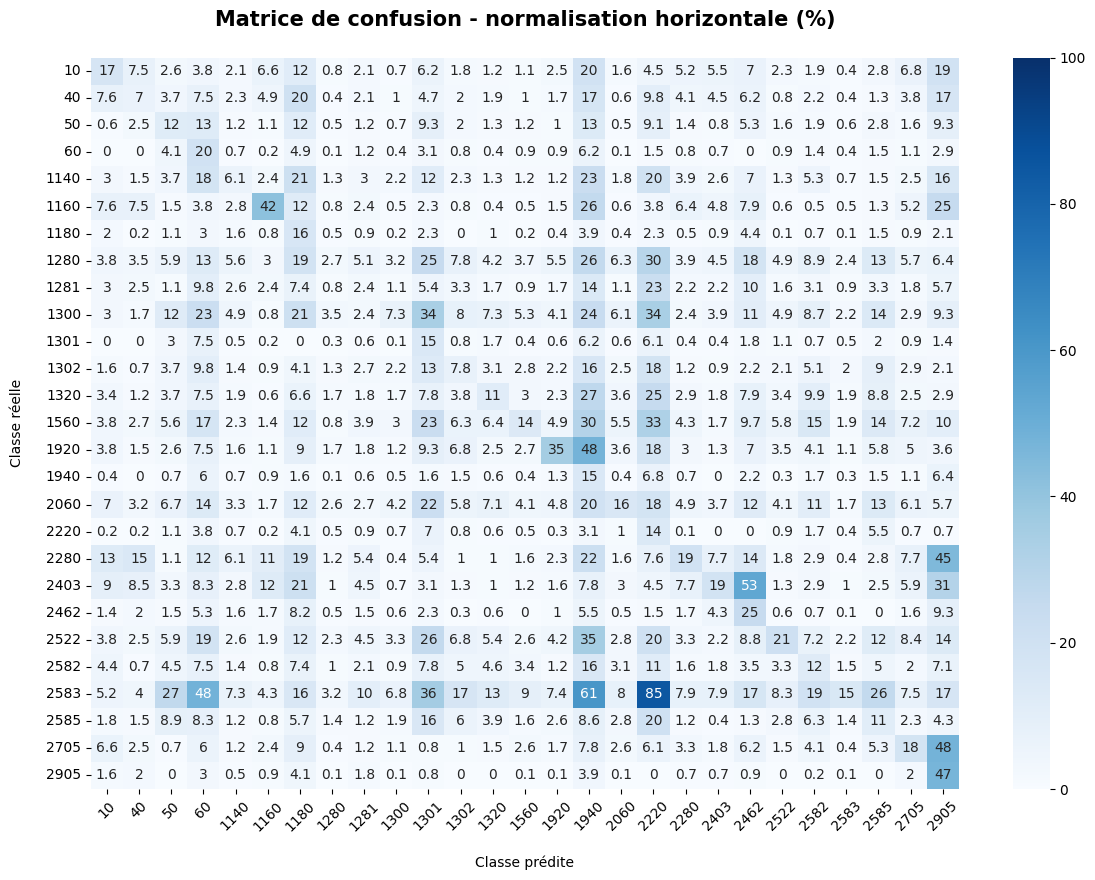

In [19]:
#Rapport de classification
y_pred = rf_img.predict(X_val_img_reduced)
print(cr(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

### Texte

In [20]:
%%time
#Entraînement du modèle
rf_txt = RandomForestClassifier(criterion = 'gini', max_depth = None, max_features = 'sqrt', n_estimators = 500)
rf_txt.fit(X_train_txt_reduced, y_train_resampled)
print(f"accuracy : {rf_txt.score(X_val_txt_reduced, y_val)}\n")

accuracy : 0.7016265547950247

CPU times: total: 3min 58s
Wall time: 3min 58s


              precision    recall  f1-score   support

          10       0.30      0.50      0.38       499
          40       0.54      0.45      0.49       401
          50       0.67      0.71      0.69       269
          60       0.86      0.74      0.80       133
        1140       0.65      0.70      0.67       427
        1160       0.86      0.75      0.80       632
        1180       0.42      0.52      0.46       122
        1280       0.66      0.37      0.47       779
        1281       0.44      0.53      0.48       331
        1300       0.81      0.80      0.81       807
        1301       0.87      0.91      0.89       129
        1302       0.75      0.65      0.70       399
        1320       0.62      0.60      0.61       519
        1560       0.75      0.69      0.72       812
        1920       0.88      0.83      0.85       689
        1940       0.56      0.84      0.67       128
        2060       0.70      0.69      0.70       799
        2220       0.55    

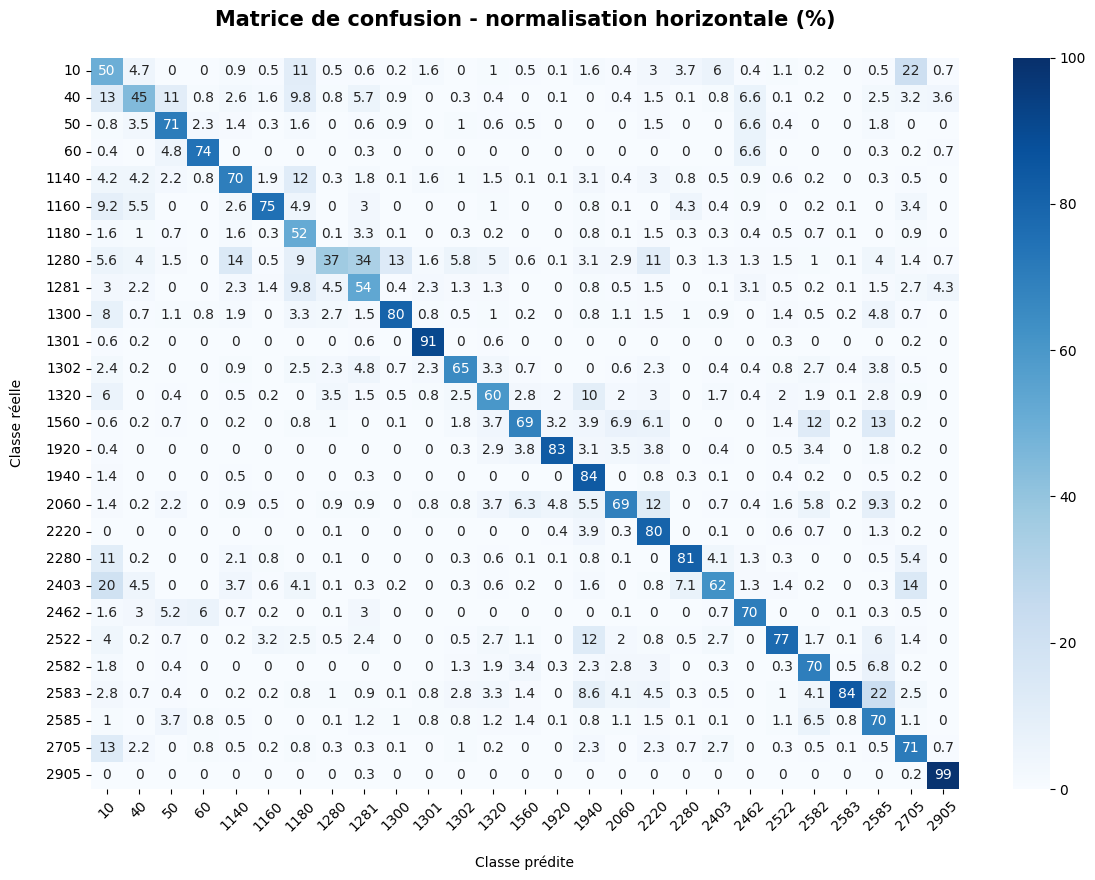

In [21]:
#Rapport de classification
y_pred = rf_txt.predict(X_val_txt_reduced)
print(cr(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

## SGD Classifier

### Images

In [22]:
%%time
#Entraînement du modèle
sgd_img = SGDClassifier(max_iter = 1000, tol = 1e-3)
sgd_img.fit(X_train_img_reduced, y_train_resampled)
print(f"accuracy : {sgd_img.score(X_val_img_reduced, y_val)}\n")

accuracy : 0.06631338779715905

CPU times: total: 38.4 s
Wall time: 38.4 s


              precision    recall  f1-score   support

          10       0.08      0.27      0.13       499
          40       0.04      0.03      0.04       401
          50       0.00      0.00      0.00       269
          60       0.00      0.00      0.00       133
        1140       0.00      0.00      0.00       427
        1160       0.00      0.00      0.00       632
        1180       0.00      0.00      0.00       122
        1280       0.10      0.02      0.03       779
        1281       0.00      0.00      0.00       331
        1300       0.00      0.00      0.00       807
        1301       1.00      0.02      0.03       129
        1302       0.00      0.00      0.00       399
        1320       0.00      0.00      0.00       519
        1560       0.05      0.36      0.09       812
        1920       0.00      0.00      0.00       689
        1940       0.00      0.00      0.00       128
        2060       0.14      0.05      0.08       799
        2220       0.00    

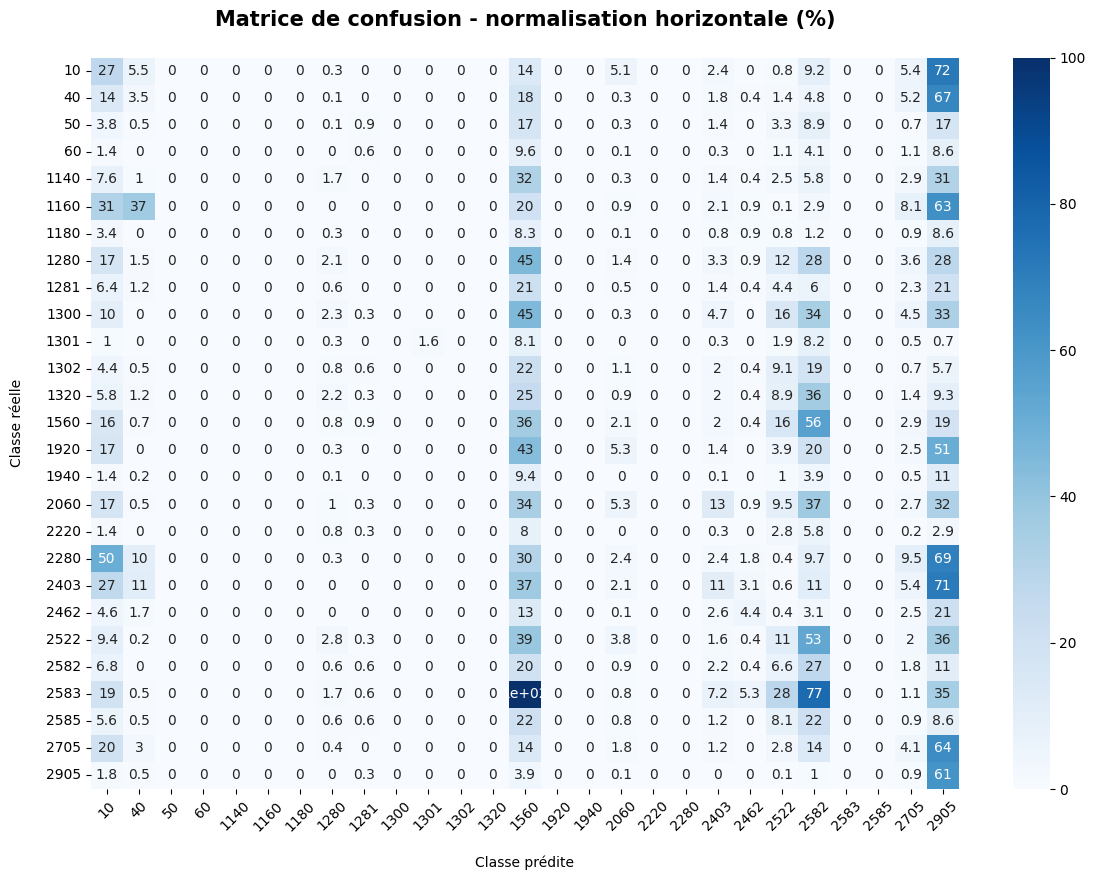

In [23]:
#Rapport de classification
y_pred = sgd_img.predict(X_val_img_reduced)
print(cr(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

### Texte

In [24]:
%%time
#Entraînement du modèle
sgd_txt = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_txt.fit(X_train_txt_reduced, y_train_resampled)
print(f"accuracy : {sgd_txt.score(X_val_txt_reduced, y_val)}\n")

accuracy : 0.6951497755207183

CPU times: total: 2.05 s
Wall time: 2.06 s


              precision    recall  f1-score   support

          10       0.30      0.53      0.38       499
          40       0.60      0.38      0.47       401
          50       0.61      0.65      0.63       269
          60       0.86      0.72      0.79       133
        1140       0.70      0.66      0.68       427
        1160       0.90      0.67      0.77       632
        1180       0.44      0.53      0.48       122
        1280       0.78      0.25      0.38       779
        1281       0.40      0.49      0.44       331
        1300       0.80      0.84      0.82       807
        1301       0.68      0.96      0.79       129
        1302       0.69      0.69      0.69       399
        1320       0.64      0.58      0.61       519
        1560       0.78      0.67      0.72       812
        1920       0.79      0.89      0.84       689
        1940       0.54      0.86      0.66       128
        2060       0.72      0.66      0.69       799
        2220       0.31    

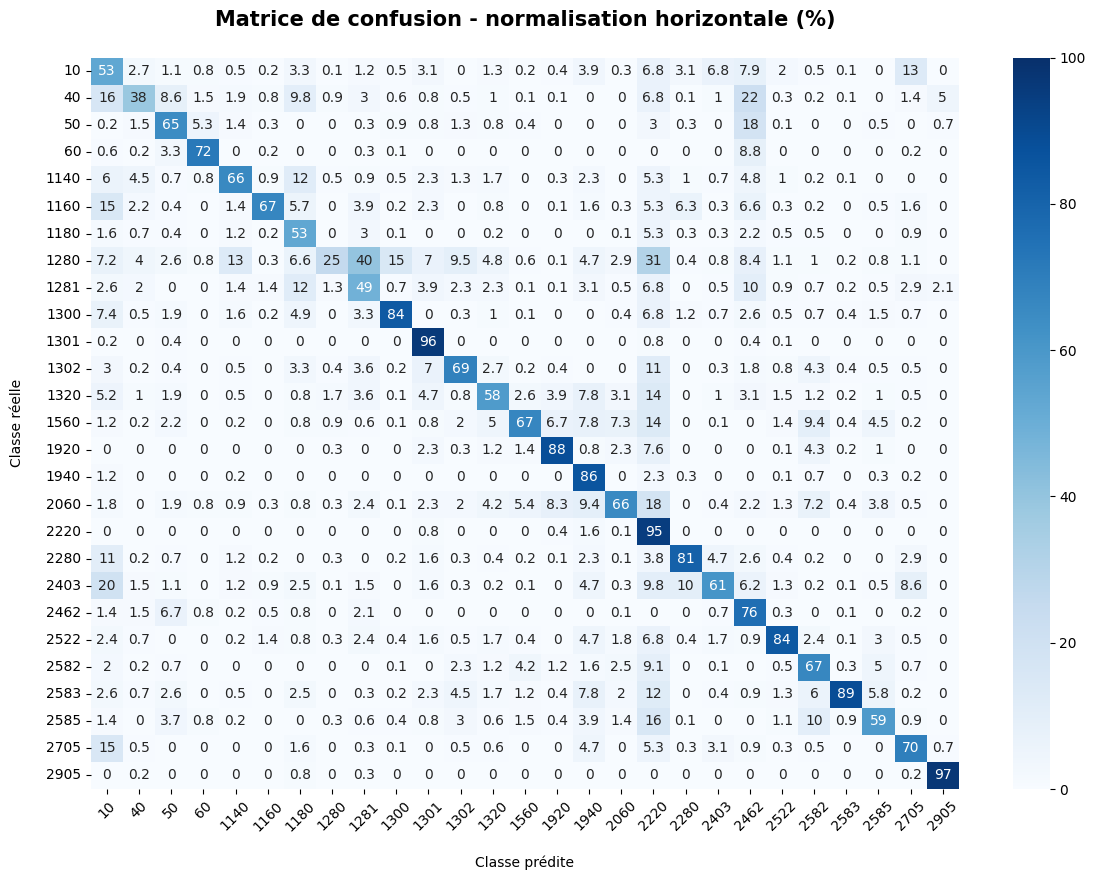

In [25]:
#Rapport de classification
y_pred = sgd_txt.predict(X_val_txt_reduced)
print(cr(y_val, y_pred))

#Matrice de confusion
cm = confusion_matrix(y_val, y_pred)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues", xticklabels = labels, yticklabels = labels, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

## LightGBM

### Images

In [26]:
%%time
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled.reshape(-1, 1))
y_val_enc = label_encoder.transform(y_val.reshape(-1, 1))


train_data = lgb.Dataset(X_train_img_reduced, label=y_train_enc)
val_data = lgb.Dataset(X_val_img_reduced, label=y_val_enc)


max_depth = 3
num_leaves = 2 ** max_depth  # 2^max_depth = 32 > 31

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 27,
    'learning_rate': 0.1,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_child_samples': 20,
    'is_unbalance': True,
    'n_estimators': 1000,
    'metric': ['multi_logloss', 'multi_error', 'auc_mu']

}

# Définition des callbacks
callbacks = [
    lgb.early_stopping(
        stopping_rounds=20,
        verbose=False
    )
]

# Entraînement du modèle avec early stopping
lgb_img = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks,
    num_boost_round=500)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 13203, number of used features: 500
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[Light

In [27]:
# Prédictions sur l'ensemble de test
y_pred_lgb = lgb_img.predict(X_val_img_reduced, num_iteration=lgb_img.best_iteration)
y_pred_lgb = [np.argmax(pred) for pred in y_pred_lgb]

# Évaluation des performances du modèle
accuracy = accuracy_score(y_val_enc, y_pred_lgb)
print("Accuracy:", accuracy)

Accuracy: 0.16206668138661956


              precision    recall  f1-score   support

          10       0.15      0.20      0.17       499
          40       0.09      0.06      0.07       401
          50       0.10      0.13      0.11       269
          60       0.05      0.16      0.08       133
        1140       0.10      0.08      0.09       427
        1160       0.33      0.46      0.39       632
        1180       0.05      0.14      0.07       122
        1280       0.13      0.02      0.03       779
        1281       0.08      0.00      0.01       331
        1300       0.15      0.06      0.09       807
        1301       0.04      0.11      0.06       129
        1302       0.05      0.03      0.03       399
        1320       0.18      0.13      0.15       519
        1560       0.20      0.15      0.18       812
        1920       0.34      0.32      0.33       689
        1940       0.03      0.18      0.05       128
        2060       0.19      0.21      0.20       799
        2220       0.03    

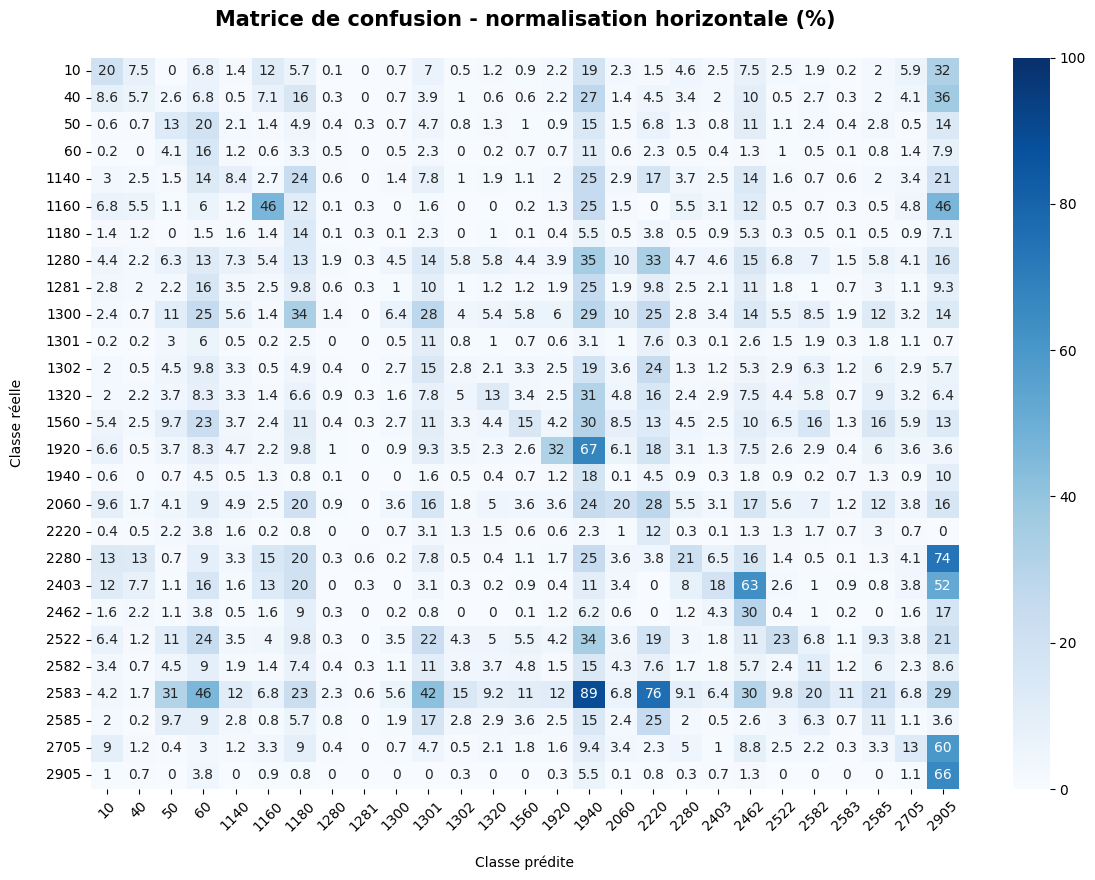

In [28]:
#Rapport de classification
print(cr(np.array(y_val_enc), np.array(y_pred_lgb), target_names=list(map(str,label_encoder.classes_))))

#Matrice de confusion
cm = confusion_matrix(y_val_enc, y_pred_lgb)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val_enc)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues",
            xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');

### Texte

In [29]:
%%time
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled.reshape(-1, 1))
y_val_enc = label_encoder.transform(y_val.reshape(-1, 1))


train_data = lgb.Dataset(X_train_txt_reduced, label=y_train_enc)
val_data = lgb.Dataset(X_val_txt_reduced, label=y_val_enc)


max_depth = 3
num_leaves = 2 ** max_depth  # 2^max_depth = 32 > 31

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 27,
    'learning_rate': 0.1,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_child_samples': 20,
    'is_unbalance' : True,
    'n_estimators':1000,
    'metric': ['multi_logloss', 'multi_error', 'auc_mu']

}

# Définition des callbacks
callbacks = [
    lgb.early_stopping(
        stopping_rounds=20,
        verbose=False
    )
]

# Entraînement du modèle avec early stopping
lgb_img = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks,
    num_boost_round=500)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 13203, number of used features: 500
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[Light

In [30]:
# Prédictions sur l'ensemble de test
y_pred_lgb = lgb_img.predict(X_val_txt_reduced, num_iteration=lgb_img.best_iteration)
y_pred_lgb = [np.argmax(pred) for pred in y_pred_lgb]

# Évaluation des performances du modèle
accuracy = accuracy_score(y_val_enc, y_pred_lgb)
print("Accuracy:", accuracy)

Accuracy: 0.7142857142857143


              precision    recall  f1-score   support

          10       0.36      0.49      0.42       499
          40       0.53      0.50      0.51       401
          50       0.66      0.74      0.70       269
          60       0.86      0.77      0.81       133
        1140       0.66      0.72      0.69       427
        1160       0.87      0.74      0.80       632
        1180       0.35      0.60      0.44       122
        1280       0.61      0.42      0.49       779
        1281       0.41      0.53      0.46       331
        1300       0.81      0.79      0.80       807
        1301       0.90      0.92      0.91       129
        1302       0.65      0.72      0.69       399
        1320       0.64      0.64      0.64       519
        1560       0.73      0.71      0.72       812
        1920       0.86      0.86      0.86       689
        1940       0.65      0.82      0.72       128
        2060       0.72      0.68      0.70       799
        2220       0.61    

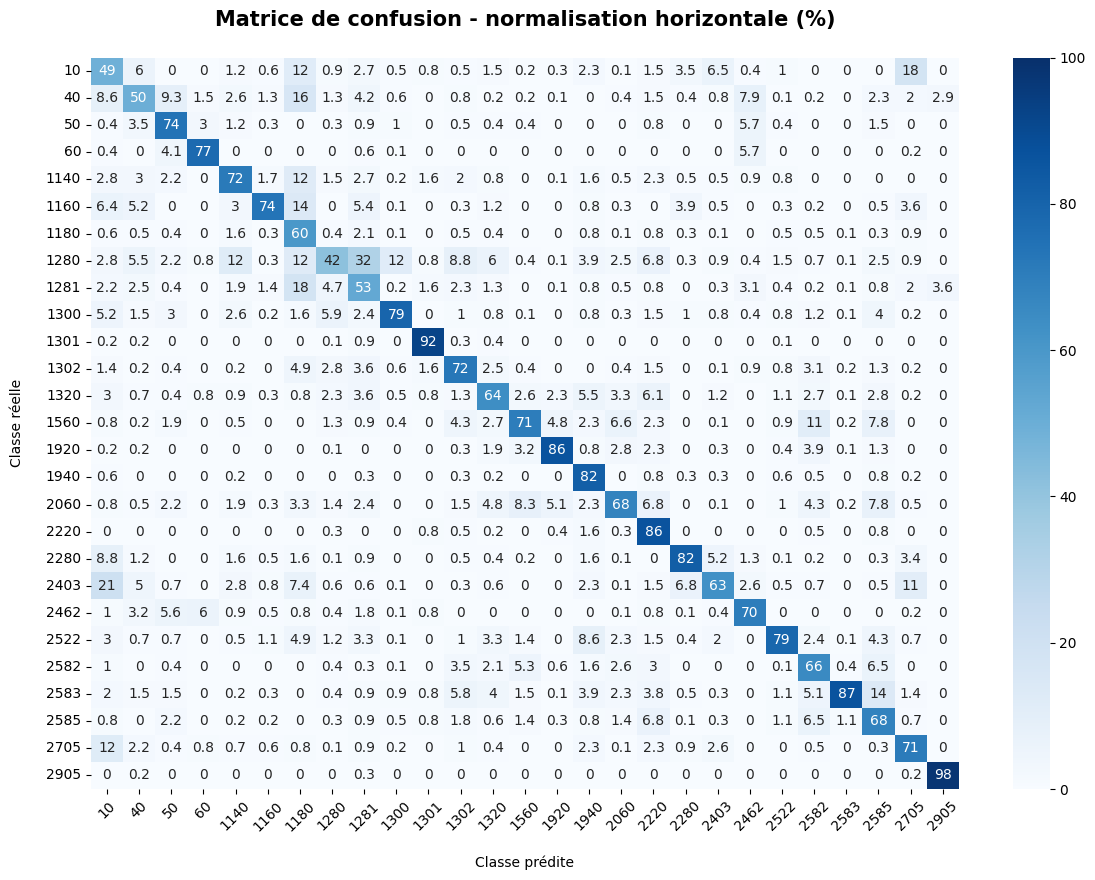

In [31]:
#Rapport de classification
print(cr(np.array(y_val_enc), np.array(y_pred_lgb), target_names=list(map(str,label_encoder.classes_))))

#Matrice de confusion
cm = confusion_matrix(y_val_enc, y_pred_lgb)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
labels = np.unique(y_val_enc)
fig, ax = plt.subplots(figsize = (14, 9.5))
plt.title('Matrice de confusion - normalisation horizontale (%)\n', fontsize = 15, fontweight = 'bold')
sns.heatmap(data = cm_normalized_horizontally, vmin = 0, vmax = 100, annot = True, cmap = "Blues",
            xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_, ax = ax)
plt.xticks(rotation = 45)
ax.set(xlabel = '\nClasse prédite', ylabel = 'Classe réelle\n');